# Assignment 1 : Spam Email Detection Using Naive Bayesian

## Importing Libraries

In [57]:
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import MultiLabelBinarizer

## Dataset Preprocessing

### Loading the dataset

In [58]:
data_directory=r'G:\My Drive\Phd Courses\CS 5841- Machine Learning\Assignments\1\spam_ham_dataset.csv'
df = pd.read_csv(data_directory)
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


### Handling Missing Values

In [59]:
# Quick overview of how many missing values are in each column
print("Missing values in each column:")
print(df.isnull().sum())

# Get the size of the imported data
imported_data_size = df.shape
print("\nImported data size:", imported_data_size)

### important point: this code was developed because df.fillna(mean_values, inplace=True) which is a common technique, did not simply work for text 


# recognizing problematic data
problematic_data=[]
for i in range(imported_data_size[0]):
    for j in range(imported_data_size[1]): 
        if pd.isnull(df.iloc[i, j]):
            print("There are some NAN values in imported data")
            #print("Data cleaning started")
            problematic_data.append([i,j])

# Cleaning problematic data: modification if possible 
for i in range(len(problematic_data)):
    temp_data=problematic_data[i]

    # we replace if the number of words is Nan by median values of the column
    if temp_data[1]==0: # specifying number of words in email column
        print ("yes")
        df.iloc[:,0]=pd.to_numeric(df.iloc[:,0],errors='coerce')
        mean_value=df.iloc[:,0].mean(skipna=True)
        df.iloc[temp_data[0],0]=mean_value
        

    # if email text or label is missed, it is not worth to keep the data, we simply remove that from initially imported set.

    else:
      df.drop( temp_data[0],inplace=True)



Missing values in each column:
Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64

Imported data size: (5171, 4)


### Text preprocessing

In [60]:
contexts = {
    "finance": ["stock", "market", "downturn", "investment", "loan", "credit", "insurance", "interest rates", "forex", "debt relief", "mortgage", "lottery", "inheritance", "refund", "bonus", "cryptocurrency", "bitcoin", "profit", "dividend", "tax"],
    "technology": ["iphone", "innovative", "features", "software", "gadget", "AI", "blockchain", "download", "hack", "update", "security", "malware", "password", "phishing", "tech support", "app", "subscription", "virtual", "cloud"],
    "weather": ["weather", "sunny", "rain", "storm", "forecast", "hurricane", "temperature", "climate", "flood", "seasonal", "tornado", "drought", "disaster", "windy", "cold front"],
    "sports": ["football", "match", "thrilling", "basketball", "soccer", "tennis", "tournament", "championship", "team", "score", "game", "coach", "training", "Olympics", "player", "league"],
    "health": ["diet", "exercise", "medication", "supplement", "cure", "weight loss", "disease", "wellness", "fitness", "healthcare", "treatment", "therapy", "pain relief", "mental health", "workout", "nutrition"],
    "shopping": ["discount", "coupon", "deal", "promo", "free", "offer", "sale", "voucher", "clearance", "price", "bargain", "shopping", "exclusive", "cashback", "buy one get one", "limited time", "membership"],
    "travel": ["flight", "vacation", "hotel", "cruise", "ticket", "package", "tour", "holiday", "destination", "cheap flights", "booking", "getaway", "airline", "passport", "visa"],
    "education": ["course", "certificate", "degree", "exam", "tutoring", "training", "scholarship", "study", "admission", "learning", "e-learning", "webinar", "online classes", "college", "program", "assignment"],
    "real_estate": ["property", "home", "real estate", "mortgage", "house", "apartment", "rent", "buy", "sell", "valuation", "foreclosure", "land", "investment property", "condo", "realtor"],
    "job_offers": ["job", "career", "opportunity", "hiring", "resume", "recruitment", "salary", "position", "work from home", "freelance", "apply now", "internship", "headhunting", "vacancy", "benefits"],
    "entertainment": ["movie", "concert", "event", "music", "streaming", "ticket", "festival", "show", "drama", "series", "celebrity", "download", "gaming", "comedy", "premiere"],
    "gambling": ["casino", "bet", "jackpot", "poker", "win", "wager", "bingo", "lottery", "prize", "spin", "slot machine", "blackjack", "roulette", "cashout"],
    "adult_content": ["dating", "romance", "explicit", "adult", "XXX", "escort", "singles", "chat", "hookup", "relationship", "flirting", "intimacy", "sexy", "nude", "privacy"],
    "scams": ["urgent", "immediate", "winner", "guarantee", "free", "claim now", "exclusive", "risk-free", "limited time", "act now", "confidential", "donation", "gift", "lottery", "fraud", "suspicious", "verify", "alert"],
    "pharmaceuticals": ["medication", "pharmacy", "drug", "prescription", "generic", "viagra", "painkiller", "treatment", "supplement", "pill", "health", "cure", "remedy", "medicine"],
    "luxury": ["luxury", "branded", "watch", "jewelry", "perfume", "designer", "exclusive", "high-end", "yacht", "premium", "gold", "diamond", "exclusive", "opulent"],
    "relationships": ["friendship", "love", "relationship", "connection", "marriage", "proposal", "partner", "dating", "romantic", "soulmate", "breakup", "couple"],
    "finance_scams": ["inheritance", "refund", "bank account", "transfer", "claim", "wire transfer", "check", "million dollars", "compensation", "money order"],
    "urgent_requests": ["asap", "immediate action", "respond quickly", "time-sensitive", "urgent", "important", "response needed", "deadline", "attention"],
    "charity": ["donation", "help", "fundraising", "relief", "support", "charitable", "nonprofit", "cause", "volunteer", "contribute"],
    "software": ["antivirus", "download", "malware", "subscription", "license", "patch", "renewal", "update", "activation", "cracked version"],
    "investment": ["ROI", "crypto", "trading", "stocks", "bonds", "real estate", "portfolio", "returns", "dividends", "mutual fund", "ETF"],
    "fashion": ["clothing", "brand", "designer", "style", "shoes", "handbags", "apparel", "wardrobe", "accessories", "sale", "limited edition"],
    "government": ["passport", "visa", "immigration", "policy", "tax", "stimulus", "grants", "legislation", "laws", "compliance", "form submission"],
    "personal_services": ["cleaning", "repair", "consultation", "advice", "coaching", "wellness", "beauty", "appointments", "booking", "therapy"],
    "cryptocurrency": ["bitcoin", "ethereum", "blockchain", "crypto", "mining", "wallet", "token", "NFT", "exchange", "investment", "decentralized"],
    "scientific_reports": ["research", "paper", "article", "experiment", "data", "analysis", "results", "supervisor", "thesis", "dissertation", "peer review", "publication", "proposal", "methodology", "findings", "journal", "submission", "revision","material","report","data","update"]
}


In [61]:
logical_flows = {
    "cause_and_effect": [
        "because", "since", "as a result", "therefore", "consequently", 
        "due to", "thus", "hence", "leads to", "results in", "is caused by"
    ],
    "comparison_contrast": [
        "similarly", "likewise", "on the other hand", "however", "in contrast", 
        "whereas", "while", "although", "yet", "unlike"
    ],
    "chronological_sequential": [
        "first", "next", "then", "after", "subsequently", "finally", 
        "before", "meanwhile", "during", "at the same time"
    ],
    "problem_and_solution": [
        "problem", "solution", "resolve", "address", "issue", 
        "remedy", "solve", "fix", "answer", "approach"
    ],
    "general_to_specific": [
        "for example", "for instance", "such as", "including", "to illustrate", 
        "in particular", "namely", "specifically", "e.g.", "i.e."
    ],
    "definition_and_description": [
        "is", "refers to", "means", "defines", "is characterized by", 
        "involves", "can be described as", "is known as", "represents", "signifies"
    ]
}

In [62]:
nltk.download('punkt_tab')
nltk.download('punkt')

nltk.download('stopwords')

# converting to lower case 
df.iloc[:,2]=df.iloc[:,2].astype(str)
print(df.iloc[:,2].dtype)
df.iloc[:,2]=df.iloc[:,2].apply(lambda x: x.lower())

# Define stop words
stop_words = set(stopwords.words('english'))

cleaned_texts = []
flow_labels_=[]
context_labels_=[]


for text in df.iloc[:, 2]:
    # Step 1: Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    
    # Step 2: Tokenize text
    words = word_tokenize(text)
    
    # Step 3: Remove stop words
    filtered_words = [word for word in words if word.lower() not in stop_words]
    
    # Step 4: Join cleaned words back into a single string
    cleaned_text = ' '.join(filtered_words)
    
    # Step 5: Label contexts
    context_labels = [
        context for context, keywords in contexts.items() 
        if any(keyword in cleaned_text.lower() for keyword in keywords)
    ]
    # Pick the context with the most matches if at least one was found
    if context_labels:
        context_labels = [
            max(
                context_labels,
                key=lambda c: sum(keyword in cleaned_text.lower() for keyword in contexts[c])
            )
        ]

    # Step 6: Label logical flows
    flow_labels = [
        flow for flow, keywords in logical_flows.items() 
        if any(keyword in cleaned_text.lower() for keyword in keywords)
    ]
    # Pick the flow with the most matches if at least one was found
    if flow_labels:
        flow_labels = [
            max(
                flow_labels,
                key=lambda f: sum(keyword in cleaned_text.lower() for keyword in logical_flows[f])
            )
        ]
    
    # Store results
    cleaned_texts.append(cleaned_text)
    flow_labels_.append(flow_labels)
    context_labels_.append(context_labels)

# Attach these new columns to the DataFrame
df["cleaned_text"]   = cleaned_texts
df["contexts"]       = context_labels_
df["logical_flows"]  = flow_labels_

print(df.head())

#  Convert each feature column into a numeric form



vectorizer_text = CountVectorizer()
X_text = vectorizer_text.fit_transform(df["cleaned_text"])



mlb_context = MultiLabelBinarizer()
X_context = mlb_context.fit_transform(df["contexts"])



mlb_flows = MultiLabelBinarizer()
X_flows = mlb_flows.fit_transform(df["logical_flows"])


# ---------------------------------------------
# 3. Combine all numeric features side by side
# ---------------------------------------------
# If you prefer everything in sparse format, convert the dense arrays:
from scipy.sparse import csr_matrix

X_context_sparse = csr_matrix(X_context)
X_flows_sparse   = csr_matrix(X_flows)

# Horizontally stack them
X = hstack([X_text, X_context_sparse, X_flows_sparse])

# Your label column 
y = df.iloc[:, 3]




[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\majidr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\majidr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\majidr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


object
   Unnamed: 0 label                                               text  \
0         605   ham  subject: enron methanol ; meter # : 988291\r\n...   
1        2349   ham  subject: hpl nom for january 9 , 2001\r\n( see...   
2        3624   ham  subject: neon retreat\r\nho ho ho , we ' re ar...   
3        4685  spam  subject: photoshop , windows , office . cheap ...   
4        2030   ham  subject: re : indian springs\r\nthis deal is t...   

   label_num                                       cleaned_text  \
0          0  subject enron methanol meter 988291 follow not...   
1          0  subject hpl nom january 9 2001 see attached fi...   
2          0  subject neon retreat ho ho ho around wonderful...   
3          1  subject photoshop windows office cheap main tr...   
4          0  subject indian springs deal book teco pvr reve...   

               contexts                 logical_flows  
0  [scientific_reports]                            []  
1                    []          

## Modeling

### Train test split

In [63]:
# spliting data to training and testing; *80% train and 20% test; "random_state=42" ensures consistant random selection thorough multiple runds

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Multinomial Naive Bayes

In [64]:
model = MultinomialNB()

model.fit(X_train, y_train)

### Predictions

y_pred_mnb = model.predict(X_test)

### Gaussian Naive Bayes

In [65]:
model = GaussianNB()

# Convert X_train and X_test to dense arrays
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

model.fit(X_train_dense, y_train)

y_pred_gnb = model.predict(X_test_dense)


## Evaluation

### Accuracy

In [67]:
accuracy_mnb = np.round(accuracy_score(y_test, y_pred_mnb),4)
accuracy_gnb = np.round(accuracy_score(y_test, y_pred_gnb),3)

print(f"Accuracy of Multinomial Naive Bayes (Percent): {accuracy_mnb*100} %")
print(f"Accuracy of Gaussian Naive Bayes (Percent): {accuracy_gnb*100} %")

Accuracy of Multinomial Naive Bayes (Percent): 97.39 %
Accuracy of Gaussian Naive Bayes (Percent): 95.5 %


### Confusion Matrix

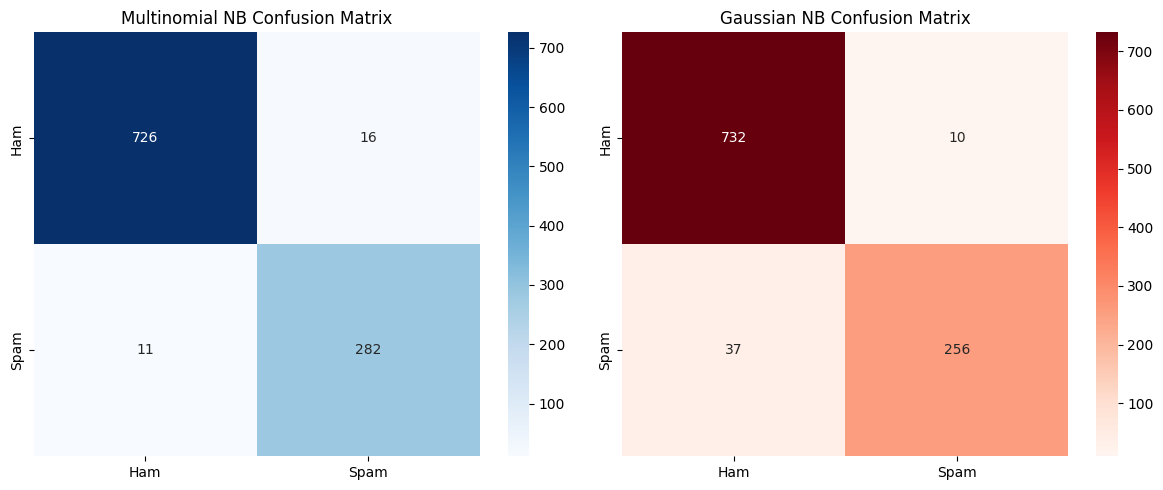

In [68]:
conf_matrix_mnb = confusion_matrix(y_test, y_pred_mnb)
conf_matrix_gnb = confusion_matrix(y_test, y_pred_gnb)

# Add heatmap visualization for confusion matrices
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_mnb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Multinomial NB Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_gnb, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Gaussian NB Confusion Matrix')
plt.tight_layout()
plt.show()

### Precision, Recall, F1 Score

In [69]:
precision_mnb, recall_mnb, f1_mnb, _ = precision_recall_fscore_support(y_test, y_pred_mnb, average='binary')
precision_gnb, recall_gnb, f1_gnb, _ = precision_recall_fscore_support(y_test, y_pred_gnb, average='binary')


print(f"Precision of Multinomial Naive Bayes: {np.round(precision_mnb,3)*100}%")
print(f"Recall of Multinomial Naive Bayes: {np.round(recall_mnb,3)*100}%")
print(f"F1 Score of Multinomial Naive Bayes: {np.round(f1_mnb,3)*100}%")
print(f"Precision of Gaussian Naive Bayes: {np.round(precision_gnb,3)*100}%")
print(f"Recall of Gaussian Naive Bayes: {np.round(recall_gnb,3)*100}%")
print(f"F1 Score of Gaussian Naive Bayes: {np.round(f1_gnb,2)*100}%")

Precision of Multinomial Naive Bayes: 94.6%
Recall of Multinomial Naive Bayes: 96.2%
F1 Score of Multinomial Naive Bayes: 95.39999999999999%
Precision of Gaussian Naive Bayes: 96.2%
Recall of Gaussian Naive Bayes: 87.4%
F1 Score of Gaussian Naive Bayes: 92.0%


### ROC Curve

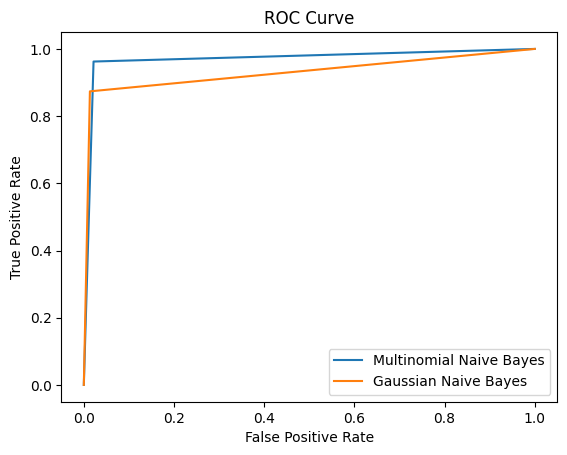

In [70]:
from sklearn.metrics import roc_curve, auc

fpr_mnb, tpr_mnb, _ = roc_curve(y_test, y_pred_mnb)
fpr_gnb, tpr_gnb, _ = roc_curve(y_test, y_pred_gnb)

roc_auc_mnb = auc(fpr_mnb, tpr_mnb)
roc_auc_gnb = auc(fpr_gnb, tpr_gnb)

sns.lineplot(x=fpr_mnb, y=tpr_mnb, label='Multinomial Naive Bayes')
sns.lineplot(x=fpr_gnb, y=tpr_gnb, label='Gaussian Naive Bayes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()